# Advanced Features and Operations of FrequencySeries

This notebook introduces the new methods and features of the `FrequencySeries` class extended in `gwexpy`.
We will focus on handling complex spectra, calculus operations, filtering (smoothing), and integration with other libraries.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from gwexpy.frequencyseries import FrequencySeries
from gwexpy.plot import Plot
from gwexpy.timeseries import TimeSeries

plt.rcParams["figure.figsize"] = (10, 6)

## 1. Data Preparation

First, we create a `FrequencySeries` from a `TimeSeries` using FFT.
Here, we generate a test signal with specific frequency components.

TimeSeries([-0.1043291 , -0.30699204, -0.09360738, ...,
             0.61143112,  1.16553834,  1.06883974]
           unit: um,
           t0: 0.0 s,
           dt: 0.0009765625 s,
           name: Test Signal,
           channel: None)
Type: <class 'gwexpy.frequencyseries.frequencyseries.FrequencySeries'>
Length: 3073
df: 0.16666666666666666 Hz


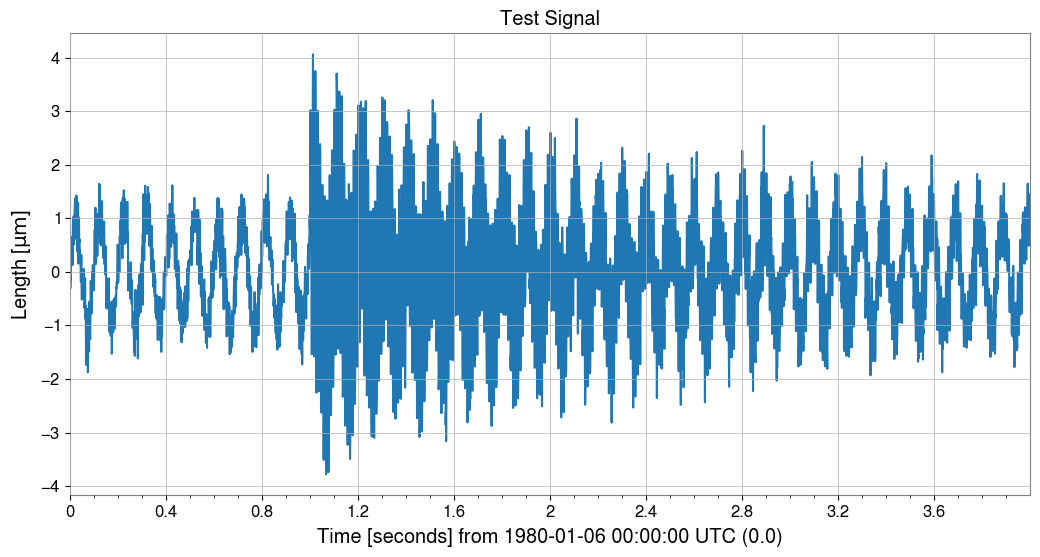

In [2]:
fs = 1024
t = np.arange(0, 4, 1 / fs)
exp = np.exp(-t / 1.5)
exp[: int(exp.size / 4)] = 0
data = (
    np.sin(2 * np.pi * 10.1 * t)
    + 5 * exp * np.sin(2 * np.pi * 100.1 * t)
    + np.random.normal(scale=0.3, size=len(t))
)
ts = TimeSeries(data, dt=1 / fs, unit="um", name="Test Signal")
print(ts)
ts.plot(title=ts.name)

# Perform FFT to obtain FrequencySeries (using transient mode with padding)
spec = ts.fft(mode="transient", pad_left=1.0, pad_right=1.0, nfft_mode="next_fast_len")
print(f"Type: {type(spec)}")
print(f"Length: {len(spec)}")
print(f"df: {spec.df}")

## 2. Visualization and Conversion of Complex Spectra

### Phase and Amplitude
Using the `phase()`, `degree()`, and `to_db()` methods, you can convert complex spectra into intuitive units.

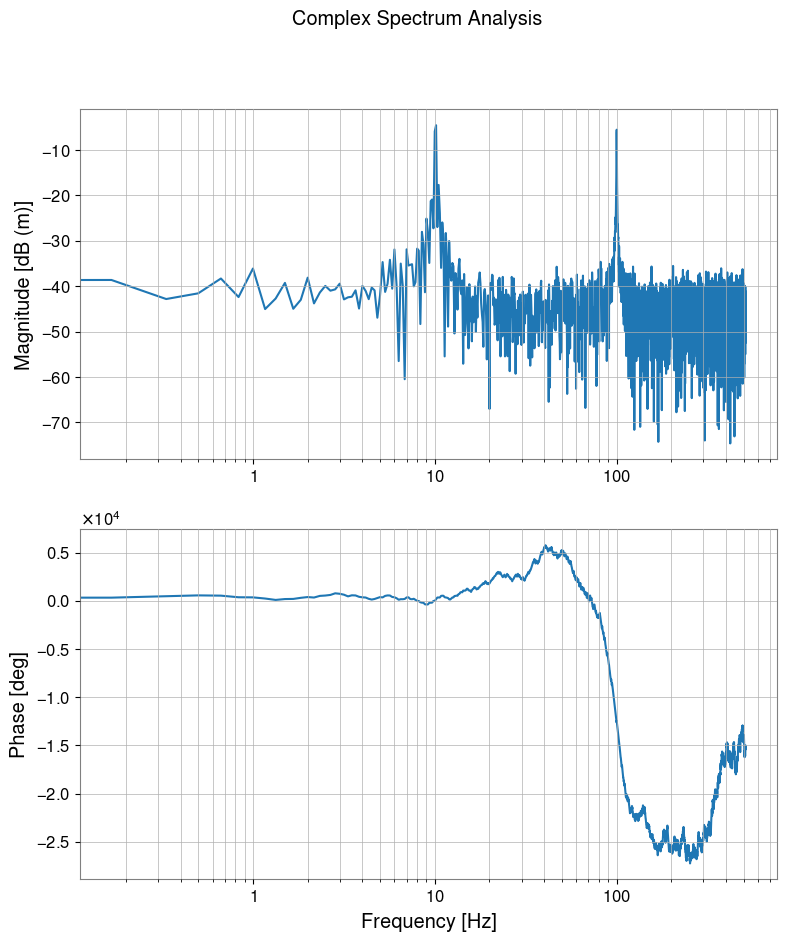

In [3]:
# Convert amplitude to dB (ref=1.0, 20*log10)
spec_db = spec.to_db()

# Get phase (in degrees, unwrap=True for continuity)
spec_phase = spec.degree(unwrap=True)

plot = Plot(spec_db, spec_phase, separate=True, sharex=True, xscale="log")
ax = plot.axes
ax[0].set_ylabel("Magnitude [dB (m)]")
ax[0].grid(True, which="both")

ax[1].set_ylabel("Phase [deg]")
ax[1].set_xlabel("Frequency [Hz]")
ax[1].grid(True, which="both")
plot.figure.suptitle("Complex Spectrum Analysis")
plot.show()

## 3. Calculus in Frequency Domain

The `differentiate()` and `integrate()` methods allow you to perform differentiation and integration in the frequency domain.
You can specify the order using the `order` argument (default is 1).
This feature makes it easy to convert between displacement, velocity, and acceleration (multiplication/division by $(2 \pi i f)^n$).

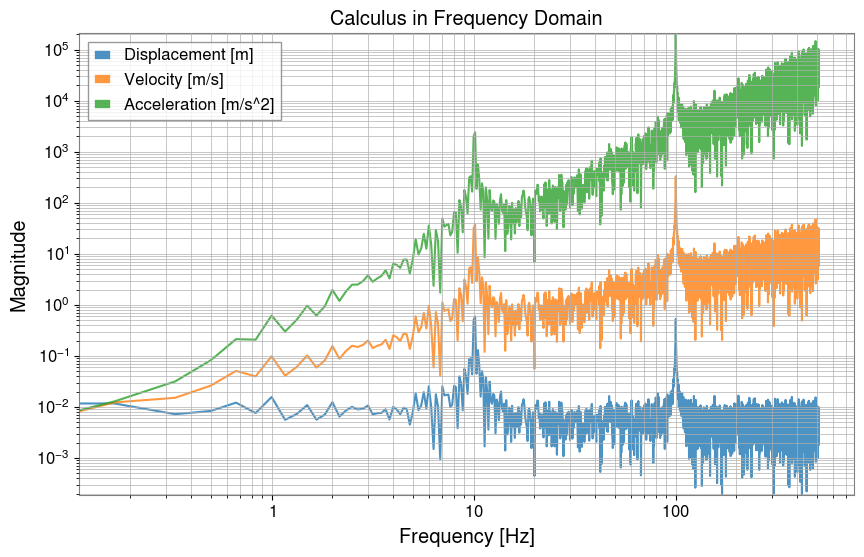

In [4]:
# Differentiate from displacement (m) to velocity (m/s) (order=1)
vel_spec = spec.differentiate()

# Differentiate from displacement (m) to acceleration (m/s^2) (order=2)
accel_spec = spec.differentiate(order=2)

# Integration is also possible: acceleration -> velocity
vel_from_accel = accel_spec.integrate()

plot = Plot(
    spec.abs(), vel_spec.abs(), accel_spec.abs(), xscale="log", yscale="log", alpha=0.8
)
ax = plot.gca()
ax.get_lines()[0].set_label("Displacement [m]")
ax.get_lines()[1].set_label("Velocity [m/s]")
ax.get_lines()[2].set_label("Acceleration [m/s^2]")
ax.legend()
ax.grid(True, which="both")
ax.set_title("Calculus in Frequency Domain")
ax.set_ylabel("Magnitude")
plot.show()

## 4. Spectrum Smoothing and Peak Detection

### Smoothing
The `smooth()` method enables smoothing of the spectrum using moving averages and other techniques.

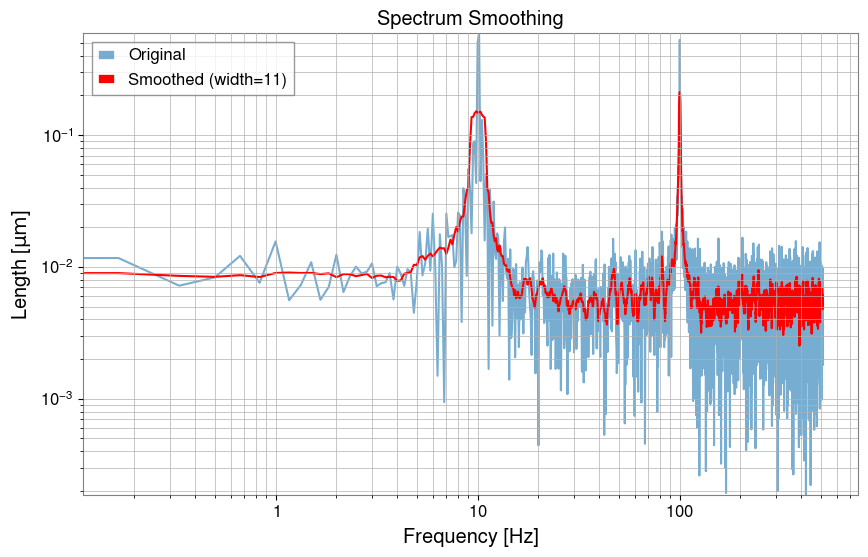

In [5]:
# Smooth in amplitude domain with 11 samples
spec_smooth = spec.smooth(width=11)

plot = Plot(spec.abs(), spec_smooth.abs(), xscale="log", yscale="log")
ax = plot.gca()
ax.get_lines()[0].set_label("Original")
ax.get_lines()[0].set_alpha(0.6)
ax.get_lines()[1].set_label("Smoothed (width=11)")
ax.get_lines()[1].set_color("red")
ax.legend()
ax.grid(True, which="both")
ax.set_title("Spectrum Smoothing")
plot.show()

### Peak Detection
The `find_peaks()` method wraps `scipy.signal.find_peaks`, making it easy to extract peaks above a specific threshold.

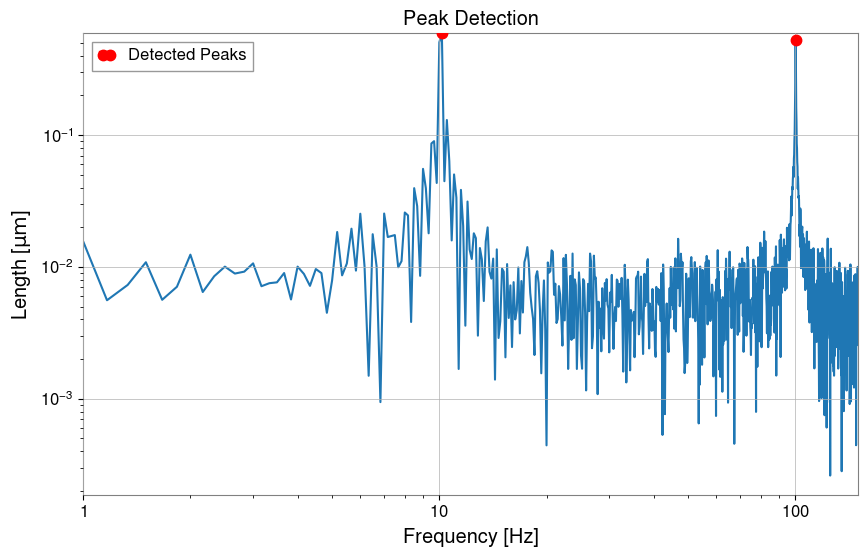

In [6]:
# Find peaks with amplitude >= 0.2
peaks, props = spec.find_peaks(threshold=0.2)

plot = Plot(spec.abs())
ax = plot.gca()
ax.plot(
    peaks.abs(), color="red", marker=".", ms=15, lw=0, zorder=3, label="Detected Peaks"
)
ax.set_xlim(1, 150)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_title("Peak Detection")
ax.legend()
plot.show()

## 5. Advanced Analysis Features

### Group Delay
The `group_delay()` method calculates the group delay (delay of the signal envelope) from the frequency derivative of the phase.

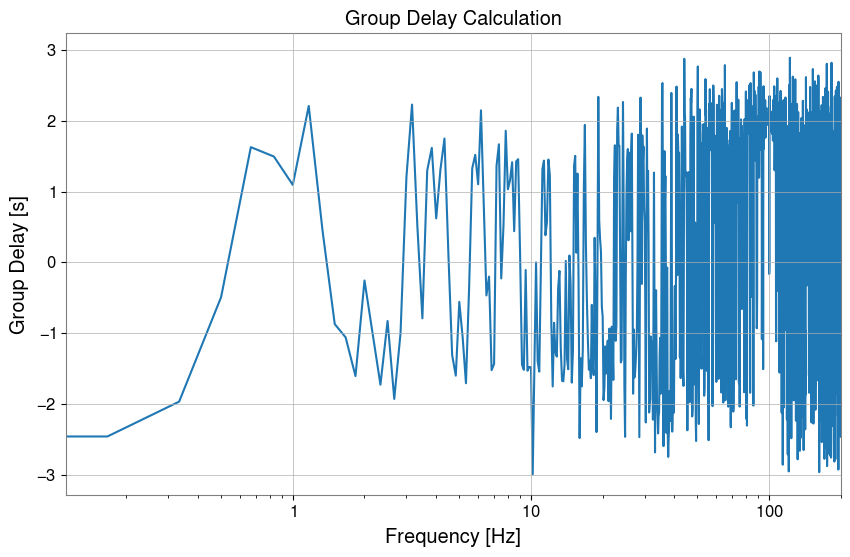

In [7]:
gd = spec.group_delay()

plot = Plot(gd)
ax = plot.gca()
ax.set_ylabel("Group Delay [s]")
ax.set_xlabel("Frequency [Hz]")
ax.set_xlim(0, 200)
ax.set_title("Group Delay Calculation")
plot.show()

### Inverse FFT (ifft)
The `ifft()` method returns a `TimeSeries`. Even for results from FFT with `mode="transient"`, it can inherit the information and control restoration to the original length (trim=True).

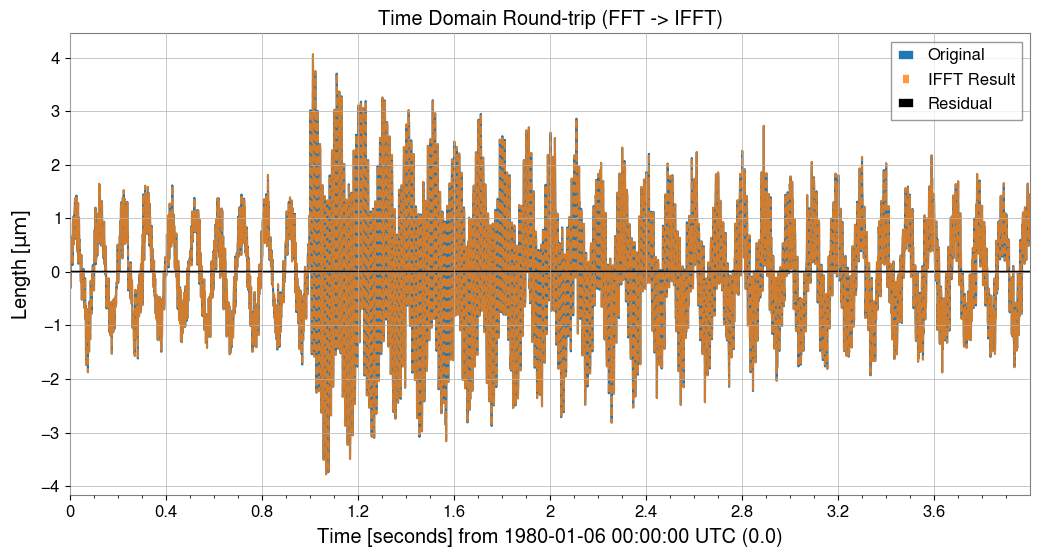

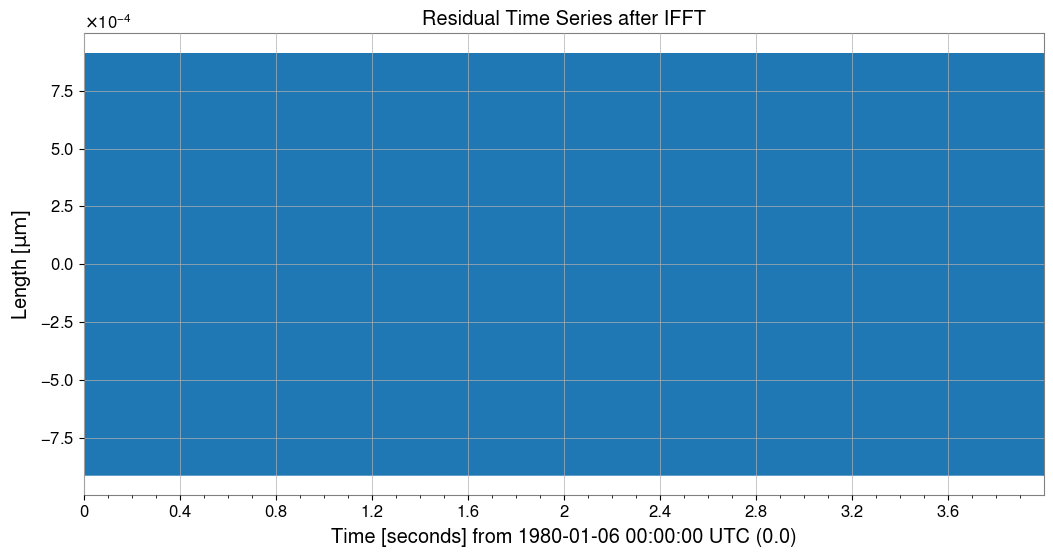

In [8]:
# Convert back to TimeSeries with inverse FFT
# mode="auto" reads the transient information from the input FrequencySeries and processes it appropriately
inv_ts = spec.ifft(mode="auto")
red_ts = inv_ts - ts

plot = Plot(ts, inv_ts, red_ts)
ax = plot.gca()
ax.get_lines()[0].set_label("Original")
ax.get_lines()[1].set_label("IFFT Result")
ax.get_lines()[2].set_label("Residual")
ax.get_lines()[1].set_linestyle("--")
ax.get_lines()[1].set_alpha(0.8)
ax.get_lines()[2].set_color("black")
ax.legend()
ax.set_title("Time Domain Round-trip (FFT -> IFFT)")
plot.show()

red_ts.plot(title="Residual Time Series after IFFT");

## 6. Integration with Other Libraries

Interconversion with Pandas, xarray, and control libraries has been added.

In [9]:
# Convert to Pandas Series
pd_series = spec.to_pandas()
print("Pandas index sample:", pd_series.index[:5])
display(pd_series)

# Convert to xarray DataArray
da = spec.to_xarray()
print("xarray coord name:", list(da.coords))
display(da)

# Convert to control.FRD (can be used for control system analysis)
try:
    from control import FRD

    _ = FRD
    frd_obj = spec.to_control_frd()
    print("Successfully converted to control.FRD")
    display(frd_obj)
except ImportError:
    print("python-control library not installed")

Pandas index sample: Index([0.0, 0.16666666666666666, 0.3333333333333333, 0.5, 0.6666666666666666], dtype='float64', name='frequency')


frequency
0.000000     -0.000279+0.000000j
0.166667      0.009523-0.006795j
0.333333     -0.003003+0.006561j
0.500000     -0.007828-0.002867j
0.666667     -0.012059+0.001405j
                     ...        
511.333333   -0.005997-0.001115j
511.500000    0.003472-0.007243j
511.666667   -0.003382+0.008113j
511.833333    0.003965-0.003591j
512.000000   -0.001815+0.000000j
Name: Test Signal, Length: 3073, dtype: complex128

xarray coord name: ['frequency']


<xarray.DataArray 'Test Signal' (frequency: 3073)> Size: 49kB
array([-0.0002791 +0.j        ,  0.00952342-0.00679493j,
       -0.00300271+0.00656129j, ..., -0.00338174+0.00811348j,
        0.00396476-0.00359085j, -0.00181507+0.j        ],
      shape=(3073,))
Coordinates:
  * frequency  (frequency) float64 25kB 0.0 0.1667 0.3333 ... 511.7 511.8 512.0
Attributes:
    unit:     um
    channel:  None
    epoch:    0.0

python-control library not installed


## 7. Integration with Python Control Library

Interconversion with the **Frequency Response Data (FRD)** object from the `control` library, which is standard in the field of control engineering, is possible.
This allows transfer functions measured with GWExPy to be directly used for control system design and analysis.

In [10]:
try:
    import control

    # Convert FrequencySeries -> control.FRD
    # Specifying frequency_unit="Hz" appropriately converts to rad/s internally
    frd_sys = fs.to_control_frd(frequency_unit="Hz")

    print("\n--- Converted to Control FRD ---")
    print(str(frd_sys)[:1000] + "\n... (truncated) ...")

    # Plot Bode diagram (control library functionality)
    control.bode(frd_sys)  # (executable if plotting environment is available)

    # Restore control.FRD -> FrequencySeries
    fs_restored = FrequencySeries.from_control_frd(frd_sys, frequency_unit="Hz")

    print("\n--- Restored FrequencySeries ---")
    print(fs_restored)

except ImportError:
    print("Python Control Systems Library is not installed.")

Python Control Systems Library is not installed.


## 8. Quadrature Sum

This feature calculates the sum of orthogonal components.

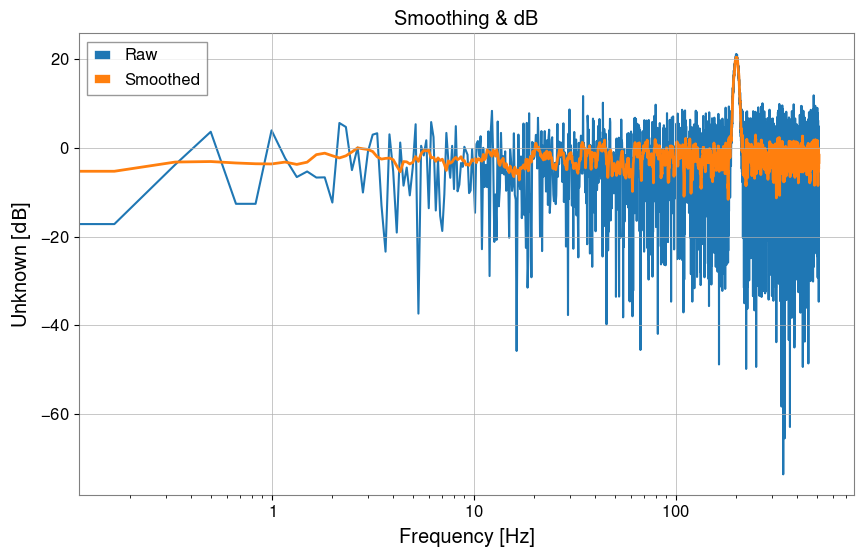

Noise A: 1.0, Noise B: 2.0
Total (Sqrt Sum): 2.23606797749979


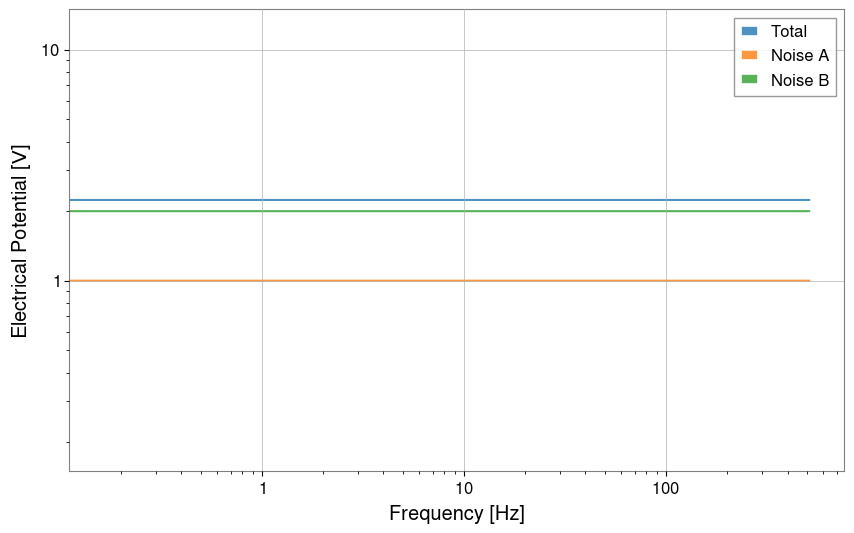

In [11]:
# Generate noisy data
np.random.seed(42)
f = spec.frequencies.value
noise = np.abs(np.random.randn(f.size))
peak = 10.0 * np.exp(-((f - 200) ** 2) / 50.0)
data = noise + peak

raw = FrequencySeries(data, frequencies=f, unit="V", name="Raw Data")

# Smooth
smoothed = raw.smooth(width=10, method="amplitude")
smoothed.name = "Smoothed"

# Convert to dB
raw_db = raw.to_db()
smoothed_db = smoothed.to_db()
raw_db.name = "Raw (dB)"
smoothed_db.name = "Smoothed (dB)"

plot = raw_db.plot(label="Raw", title="Smoothing & dB")
ax = plot.gca()
ax.plot(smoothed_db, label="Smoothed", linewidth=2)
ax.legend()
plot.show()
plt.close()

# Quadrature Sum (Noise Budget example)
noise_a = FrequencySeries(np.ones_like(f), frequencies=f, unit="V", name="Noise A")
noise_b = FrequencySeries(np.ones_like(f) * 2, frequencies=f, unit="V", name="Noise B")

total = noise_a.quadrature_sum(noise_b)
print(f"Noise A: {noise_a.value[0]}, Noise B: {noise_b.value[0]}")
print(f"Total (Sqrt Sum): {total.value[0]}")
Plot(total, noise_a, noise_b, alpha=0.8)
plt.legend(["Total", "Noise A", "Noise B"])
plt.xscale("log")
plt.yscale("log")
plt.show()